In [11]:
using MIDI
using MusicVisualizations, PyPlot, MusicManipulations, ColorSchemes

ArgumentError: ArgumentError: Package ColorSchemes not found in current path.
- Run `import Pkg; Pkg.add("ColorSchemes")` to install the ColorSchemes package.

In [12]:
# Write a C scale to MIDI
# MIDI.ms_per_tick(100, 10)
tpq = 960

C = Note(name_to_pitch("C4"), 10, tpq, tpq)
D = Note(name_to_pitch("D4"), 20, 2*tpq, tpq)
E = Note(name_to_pitch("E4"), 30, 3*tpq, tpq)
F = Note(name_to_pitch("F4"), 40, 4*tpq, tpq)
G = Note(name_to_pitch("G4"), 50, 5*tpq, tpq)
A = Note(name_to_pitch("A4"), 60, 6*tpq, tpq)
B = Note(name_to_pitch("B4"), 70, 7*tpq, tpq)
C5 = Note(name_to_pitch("C5"), 127, 8*tpq, tpq)

file = MIDIFile()
track = MIDITrack()
notes = Notes()

function bpm_to_microseconds(bpm)
    return round(Int, 60000000/bpm)
end

push!(track.events, MIDI.SetTempoEvent(0, bpm_to_microseconds(120))) # dT, metatype
push!(track.events, MIDI.TimeSignatureEvent(0, 4, 4, 24, 8))

println(track.events)

# add notes to the track
push!(notes, C)
push!(notes, D)
push!(notes, E)
push!(notes, F)
push!(notes, G)
push!(notes, A)
push!(notes, B)
push!(notes, C5)


addnotes!(track,notes)
println(track.events)


addtrackname!(track, "Piano")
push!(file.tracks, track)
save("C_scale.mid", file)


TrackEvent[MIDI.SetTempoEvent(0, 0x51, 500000), MIDI.TimeSignatureEvent(0, 0x58, 4, 4, 24, 8)]
TrackEvent[MIDI.SetTempoEvent(0, 0x51, 500000), MIDI.TimeSignatureEvent(0, 0x58, 4, 4, 24, 8), MIDI.NoteOnEvent(960, 0x90, 60, 10), MIDI.NoteOffEvent(960, 0x80, 60, 10), MIDI.NoteOnEvent(0, 0x90, 62, 20), MIDI.NoteOffEvent(960, 0x80, 62, 20), MIDI.NoteOnEvent(0, 0x90, 64, 30), MIDI.NoteOffEvent(960, 0x80, 64, 30), MIDI.NoteOnEvent(0, 0x90, 65, 40), MIDI.NoteOffEvent(960, 0x80, 65, 40), MIDI.NoteOnEvent(0, 0x90, 67, 50), MIDI.NoteOffEvent(960, 0x80, 67, 50), MIDI.NoteOnEvent(0, 0x90, 69, 60), MIDI.NoteOffEvent(960, 0x80, 69, 60), MIDI.NoteOnEvent(0, 0x90, 71, 70), MIDI.NoteOffEvent(960, 0x80, 71, 70), MIDI.NoteOnEvent(0, 0x90, 72, 127), MIDI.NoteOffEvent(960, 0x80, 72, 127)]


MIDIFile (format=1, tpq=960) with tracks:
 Piano


MIDI INFO
midi.tpq = 960
qpm(midi) = 120.0
bpm(midi) = 120.0
ms_per_tick(midi) = 0.5208333333333334
midi.tracks = MIDITrack[19-event MIDITrack: 16 MIDI, 3 Meta, 0 Sysex]
notes = Notes{Note} with 8 notes
total_ticks = calculate_total_ticks(midi) + 1000 = 9640

Unique Keys: ["G4", "D4", "C4", "A4", "E4", "F4", "B4", "C5"]
color_mapping[1] = (0.267004, 0.004874, 0.329415, 1.0)
color_mapping[2] = (0.127568, 0.566949, 0.550556, 1.0)
color_mapping[3] = (0.993248, 0.906157, 0.143936, 1.0)


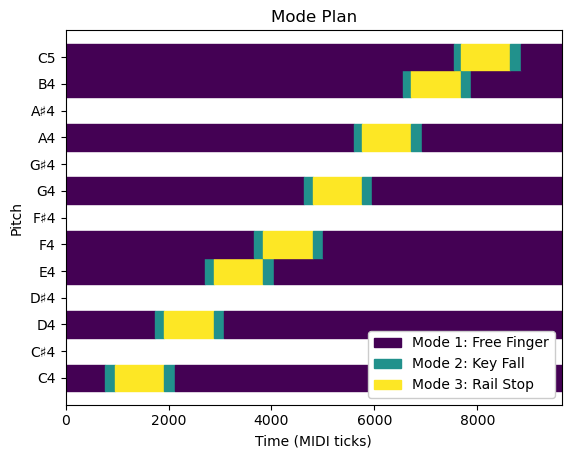

In [15]:
# Read MIDI file
midi = load("C_scale.mid")
# midi = load("bach_846.mid")
piano = midi.tracks[1]
notes = getnotes(piano, midi.tpq)

# Show info about midi file
println("MIDI INFO")
println("===========")
@show midi.tpq
@show qpm(midi)
@show bpm(midi)
@show ms_per_tick(midi)

@show midi.tracks
@show notes

function calculate_total_ticks(midi)
    total = 0
    for track in midi.tracks
        for event in track.events
            total += event.dT
        end
    end
    return total
end


# total_ticks = 960*9+1+500
@show total_ticks = calculate_total_ticks(midi)+1000


println()

# Initialize mode dict with unique pitch names
unique_pitch_names = collect(Set(pitch_to_name(note.pitch) for note in notes))
mode_dict = Dict(pitch => ones(total_ticks) for pitch in unique_pitch_names)

println("Unique Keys: ", keys(mode_dict))

function get_key_fall_duration(note_velocity)
    max_speed_duration = 2
    velocity_scaling = 0.5
    duration = UInt64(round(velocity_scaling*(-note_velocity+127) + max_speed_duration))
    return duration
end

function get_key_rise_duration()
    return UInt64(200)
end

# Iterate through notes and assign modes
for note in notes
    # set the key to be in the key fall phase based on note velocity
    # key_fall_duration =  UInt64(round(200/(5*note.velocity+10)))
    # println("Key Fall Duration: ", round(2*(-note.velocity+127)+2))
    # key_fall_duration = UInt64(round(2*(-note.velocity+127)+2))
    key_fall_duration = get_key_fall_duration(note.velocity)

    # Check if the required prep time for the fall phase starts before t=1
    if note.position-key_fall_duration > 1 
        mode_dict[pitch_to_name(note.pitch)][1 .+ collect(note.position-key_fall_duration : note.position)] .=2
    else
        mode_dict[pitch_to_name(note.pitch)][1 .+ collect(1 : note.position)] .=2 # if so, set the beginning of the fall mode to t=1
    end

    
    # Set the key to bottom out for the duration of the note
    mode_dict[pitch_to_name(note.pitch)][1 .+ collect(note.position : (note.position+note.duration))] .= 3 

    # Add another mode 2 at the end of the note for the lifting phase
    key_rise_duration = get_key_rise_duration()
    mode_dict[pitch_to_name(note.pitch)][1 .+ collect(note.position+note.duration) : key_rise_duration .+ collect(note.position+note.duration)] .=2
end



# Define a colormap
cmap = PyPlot.cm.get_cmap("viridis")

# Define a color mapping for your three values
color_mapping = Dict(
    1 => cmap(0.0),  # Map 1 to the first color in the colormap
    2 => cmap(0.5),  # Map 2 to the middle color in the colormap
    3 => cmap(1.0)   # Map 3 to the last color in the colormap
)

# Now you can use `color_mapping` to get the color for a value
value = 1

@show color_mapping[1]
@show color_mapping[2]
@show color_mapping[3]

last_mode = 0
last_mode_index = 0
ax = (PyPlot.figure(); PyPlot.gca())

for (pitch, mode_array) in mode_dict # iterate through each pitch 
    last_mode = mode_array[1]
    last_mode_index = 1
    for (index, mode) in enumerate(mode_array) # iterate through time steps per pitch
        if mode != last_mode || index == length(mode_array)
            # plot a rectangle for the previous mode duration if we encounter a new mode
            r = PyPlot.matplotlib.patches.Rectangle((last_mode_index, name_to_pitch(pitch) - 0.5), index - last_mode_index, 1, color=color_mapping[last_mode])
            ax.add_artist(r)
            last_mode = mode
            last_mode_index = index
        end
    end
    last_mode = 0
end

# @show mode_array = mode_dict["C4"]
# last_mode = 3
# for (index, mode) in enumerate(mode_array) # iterate through time steps per pitch
#     if mode != last_mode || index == length(mode_array)
#         # plot a rectangle for the previous mode duration if we encounter a new mode
#         r = PyPlot.matplotlib.patches.Rectangle((last_mode_index, name_to_pitch("C4") - 0.5), index - last_mode_index, 1, color=color_mapping[last_mode])
#         ax.add_artist(r)
#         @show last_mode = mode
#         last_mode_index = index
#     end

# end
# last_mode = 0
    


function heuristic_note_names(plottedpitches)
    mi, ma = extrema(plottedpitches)
    notestep = max((ma-mi)÷7, 1)
    pitches = mi:notestep:ma
    ylabels = [pitch_to_name(p) for p in pitches]
    return pitches, ylabels
end


unique_pitches = collect(Set(note.pitch for note in notes))
min_pitch = Int(minimum(unique_pitches))
max_pitch = Int(maximum(unique_pitches))

yticks, ylabels = heuristic_note_names(unique_pitches)

ax.set_xlim(0, total_ticks)
ax.set_ylim(min_pitch-1, max_pitch+1)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_title("Mode Plan")

# Define a label mapping for your three values
label_mapping = Dict(
    1 => "Mode 1: Free Finger",
    2 => "Mode 2: Key Fall",
    3 => "Mode 3: Rail Stop"
)

PyPlot.xlabel("Time (MIDI ticks)")
PyPlot.ylabel("Pitch")

# Create some dummy patches for the legend
patches = [PyPlot.matplotlib.patches.Patch(color=color_mapping[i], label=label_mapping[i]) for i in 1:3]

# Add the legend to the plot
PyPlot.subplots_adjust(bottom=0.1)
PyPlot.legend(handles=patches, loc="lower right",framealpha=1)

display(gcf())



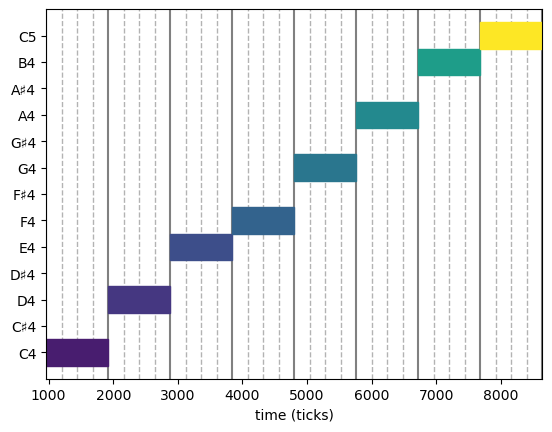

grid = 0:1 // 4:1 = 0//1:1//4:1//1
notes.tpq = 960


In [16]:
@show grid = 0:1//4:1
grid = 0:0.25:1
@show notes.tpq
ax_notes = (PyPlot.figure(); PyPlot.gca())
noteplotter(notes; grid = grid, fi=Inf, ax=ax_notes)

savefig("ax_notes.png")
display(gcf())



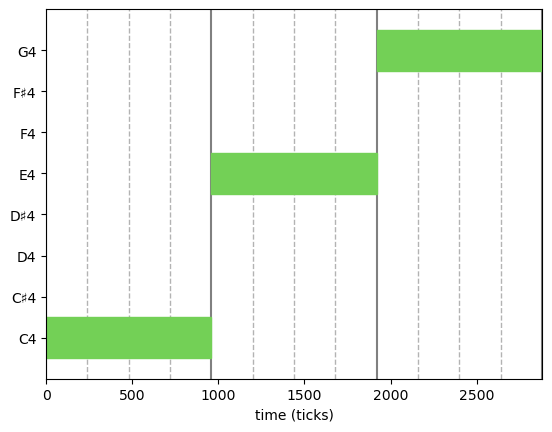

grid = 0//1:1//4:1//1
typeof(grid) = StepRange{Rational{Int64}, Rational{Int64}}


In [27]:

# Note(pitch, velocity, position, duration, channel = 0) <: AbstractNote
C = Note("C4";position=0)
E = Note("E4";position=960)
G = Note("G4";position=1920)

file = MIDIFile()
track = MIDITrack()
notes = Notes() # tpq automatically = 960

push!(notes, C)
push!(notes, E)
push!(notes, G)



addnotes!(track, notes)
addtrackname!(track, "piano")
push!(file.tracks, track)
save("./midi_files/3note.mid", file)

# Read
midi = readMIDIFile("./midi_files/3note.mid")
grid = 0:1//4:1
@show grid
@show typeof(grid)
piano = getnotes(midi, 1)
noteplotter(piano; grid = grid, fi=Inf)
display(gcf())